In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

78876 rows of dihiggs data Index(['hh_mass', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'h2_pt',
       'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)',
       'deltaPhi(h1, h2)', 'deltaPhi(h1 jets)', 'deltaPhi(h2 jets)', 'met',
       'met_phi', 'scalarHT', 'nJets', 'nBTags', 'isMatchable', 'jet1_pt',
       'jet2_pt', 'jet3_pt', 'jet4_pt', 'jet1_eta', 'jet2_eta', 'jet3_eta',
       'jet4_eta', 'jet1_phi', 'jet2_phi', 'jet3_phi', 'jet4_phi', 'jet1_mass',
       'jet2_mass', 'jet3_mass', 'jet4_mass', 'jet1_px', 'jet2_px', 'jet3_px',
       'jet4_px', 'jet1_py', 'jet2_py', 'jet3_py', 'jet4_py', 'jet1_pz',
       'jet2_pz', 'jet3_pz', 'jet4_pz', 'jet1_energy', 'jet2_energy',
       'jet3_energy', 'jet4_energy', 'jet1_btag', 'jet2_btag', 'jet3_btag',
       'jet4_btag', 'isSignal'],
      dtype='object')
29176 rows of qcd data Index(['hh_mass', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'h2_pt',
       'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)',
       'deltaPhi(h1, h2)', 'de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a71976490>]],
      dtype=object)

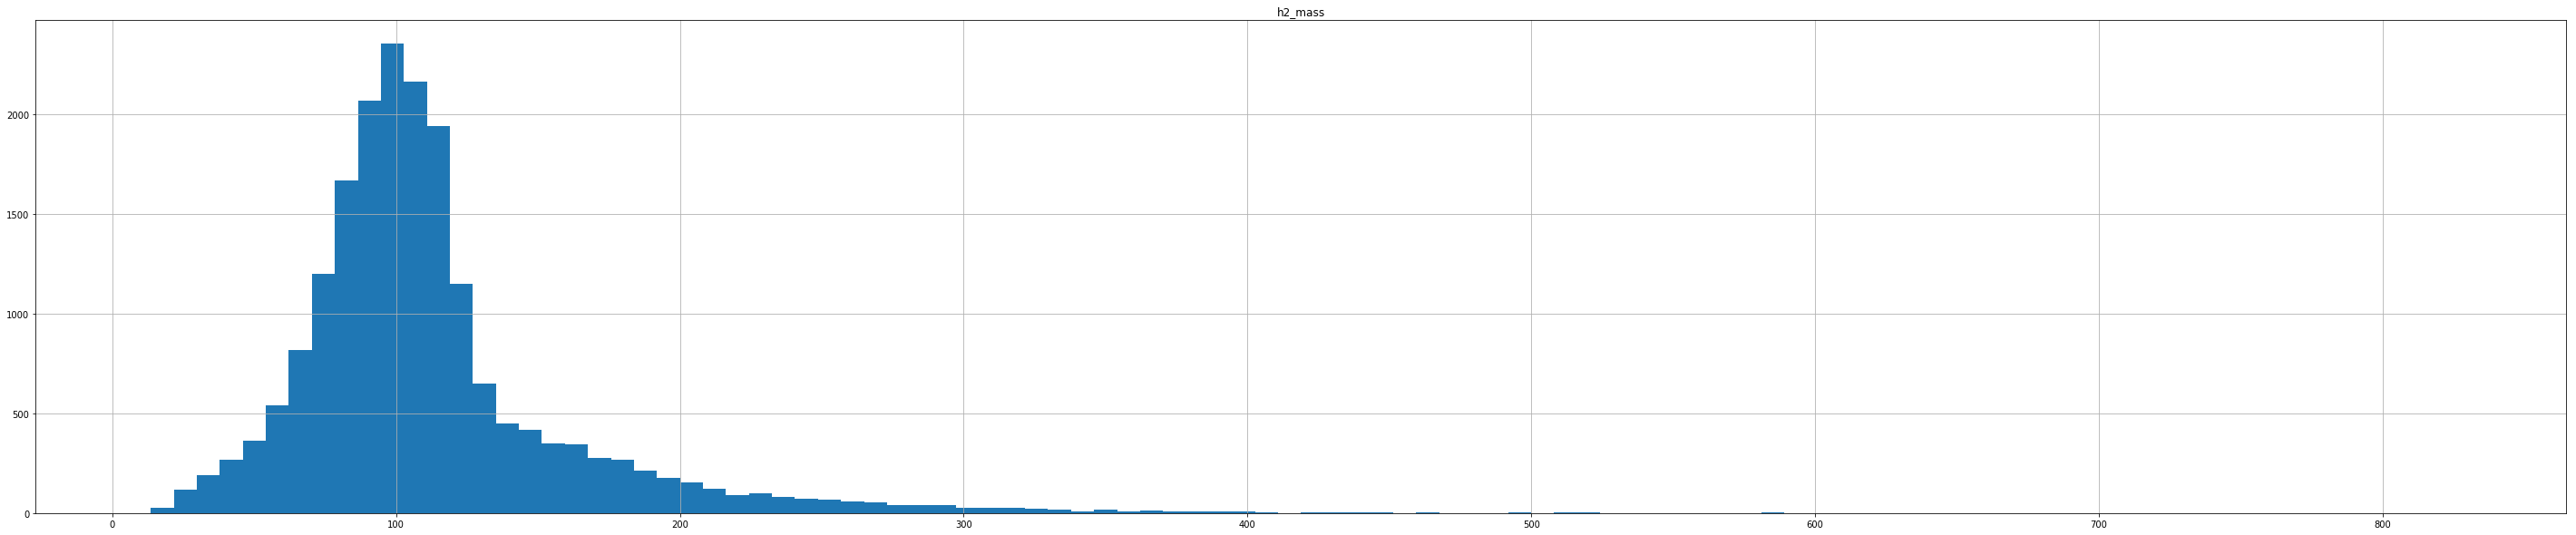

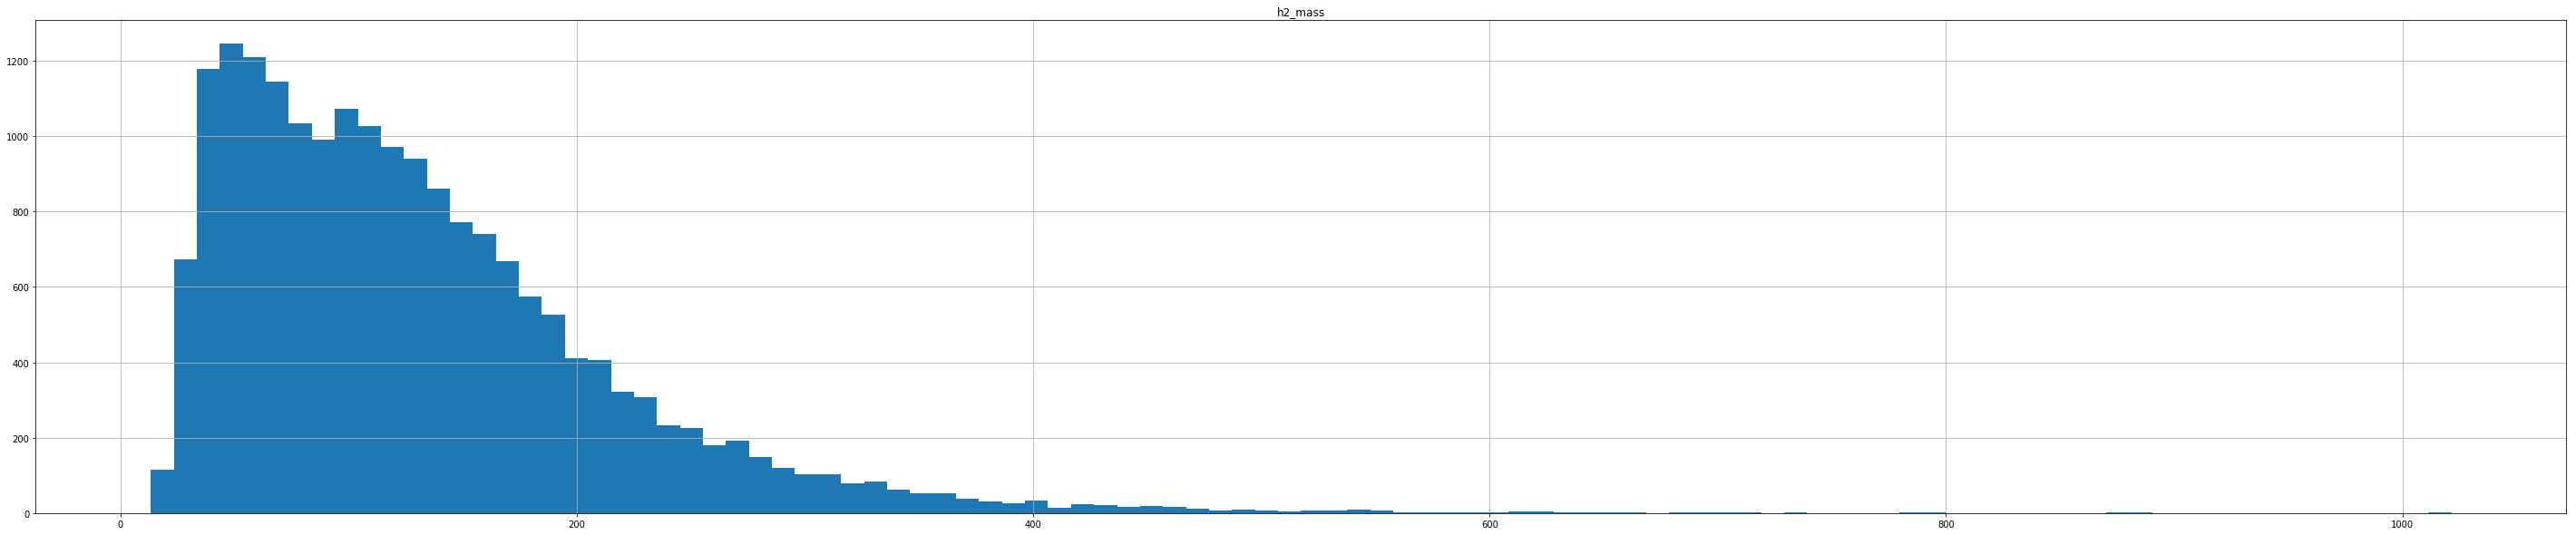

In [36]:
# *** 0. Import Dataset
qcd_raw = pd.read_csv('../samples_500k/qcd_outputDataForLearning.csv')
hh_raw = pd.read_csv('../samples_500k/dihiggs_outputDataForLearning.csv')

hh_raw.head()
hh_raw['isSignal'] = 1
print(len(hh_raw), "rows of dihiggs data", hh_raw.columns)
#print( print(hh_raw.loc[[10]]))

qcd_raw.head()
qcd_raw['isSignal'] = 0
print(len(qcd_raw), "rows of qcd data", qcd_raw.columns)

variableNames = ['hh_mass', 'h1_mass', 'h2_mass']
#variableNames = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']
#variableNames = ['hh_mass', 'h1_mass', 'h2_mass', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']

hh_massesOnly_data.hist(column=variableNames[2], bins=100)
qcd_massesOnly_data.hist(column=variableNames[2], bins=100)


In [3]:
def makeEqualSamplesWithUserVariables(signal_raw, bkg_raw, userVariables, nEventsForXGB):
    """function to return 4 dataframes containing user-specified variables and number of events: 1 signal for training, 1 bkg for training, 1 signal for plotting, 1 bkg for plotting"""
    
    # *** 0. Reduce dataframes to only desired variables
    signal_reduced  = signal_raw[userVariables]
    bkg_reduced     = bkg_raw[userVariables]
    signal_labels   = signal_raw[ ['isSignal'] ]
    bkg_labels      = bkg_raw[ ['isSignal'] ]

    # *** 1. Take first nEventsForXGB events for passing to XGB 
    signal_reducedForXGB  = signal_reduced[:nEventsForXGB]
    bkg_reducedForXGB     = bkg_reduced[:nEventsForXGB]
    signal_labelsForXGB   = signal_labels[:nEventsForXGB]
    bkg_labelsForXGB      = bkg_labels[:nEventsForXGB]

    # *** 2. Combine bkg+signal for passing to XGB 
    all_reducedForXGB  = signal_reducedForXGB.append(bkg_reducedForXGB)
    all_labelsForXGB   = signal_labelsForXGB.append(bkg_labelsForXGB)

    
    # ** 3. Use additional events for unambiguous testing 
    signal_reducedForPlots  = signal_reduced[nEventsForXGB:len(bkg_reduced)]
    bkg_reducedForPlots     = bkg_reduced[nEventsForXGB:len(bkg_reduced)]
    signal_labelsForPlots   = signal_labels[nEventsForXGB:len(bkg_reduced)]
    bkg_labelsForPlots      = bkg_labels[nEventsForXGB:len(bkg_reduced)]

    # *** 4. Sanity check
    print(len(all_reducedForXGB), 'rows of data with ', len(all_labelsForXGB), 'labels [XGB]')
    print(len(signal_reducedForPlots), 'rows of signal data with ', len(bkg_labelsForPlots), 'rows of background [Plots]')

    
    return all_reducedForXGB, all_labelsForXGB, signal_reducedForPlots, signal_labelsForPlots, bkg_reducedForPlots, bkg_labelsForPlots

In [29]:
def setupAndTrainBDT(all_data, all_labels, _testSize=0.3, _dumpModelInfo=False):
    """setup and train BDT"""
    
    # *** 1. Split dataset into test + train, make correct input objects
    data_train, data_test, label_train, label_test = train_test_split(all_data, all_labels, test_size=_testSize)

    D_train = xgb.DMatrix(data_train, label=label_train)
    D_test = xgb.DMatrix(data_test, label=label_test)
    
    # *** 2. Define XGB model 
    param = {
        'eta': 0.3, 
        'max_depth': 3,  
        'objective': 'multi:softprob',  
        #'objective': 'reg:logistic',  
        #'objective': 'binary:logistic',
        'num_class': 2} 

    steps = 5  # The number of training iterations

    # *** 3. Train model 
    model = xgb.train(param, D_train, steps)
    
    # *** 4. Evaluate model
    preds = model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])

    print("Precision = {}".format(precision_score(label_test, best_preds, average='macro')))
    print("Recall = {}".format(recall_score(label_test, best_preds, average='macro')))
    print("Accuracy = {}".format(accuracy_score(label_test, best_preds)))
    
    # *** 5. Dump .txt of trees and leaves with decisions if desired
    if (_dumpModelInfo):
        model.dump_model('dumpTree.reduced_bdt.txt')

        # Make a visual of decision tree
        xgb.plot_tree(model,num_trees=1)
        #plt.rcParams['figure.figsize'] = [2000, 400]
        #plt.show()
        plt.savefig('tree0.png')
    
    
    return model

def compareManyHistograms( _dict, _labels, _nPlot, _title, _xtitle, _xMin, _xMax, _nBins, _normed=False):
       
    if len(_dict.keys()) < len(_labels):
        print ("!!! Unequal number of arrays and labels. Learn to count better.")
        return 0
    
    plt.figure(_nPlot)
    if _normed:
        plt.title(_title + ' (Normalized)')
    else:
        plt.title(_title)
    plt.xlabel(_xtitle)
    _bins = np.linspace(_xMin, _xMax, _nBins)
   
    y_max = 0
    for iLabel in _labels:
        plt.hist(_dict[iLabel], _bins, alpha=0.5, density=_normed, label= iLabel+' Events')
        
        # get values of histgoram to find greatest y
        #_y, _x, _ = plt.hist(_dict[iLabel])
        #if (_y.max() > y_max):
        #    y_max = _y.max()
    
    # set max y-value of histogram so there's room for legend
    axes = plt.gca()
    axes.set_ylim([0,11000])
    #plt.ylim([0,1.2*y_max])
    
    #draw legend
    plt.legend(loc='upper right')
    #plt.text(.1, .1, s1)
    
    # store figure copy for later saving
    fig = plt.gcf()
    
    # draw interactively
    plt.show()
    
   
    
    # save an image files
    #_scope    = _title.split(' ')[0].lower()
    #_variable = _xtitle.lstrip('Jet Pair').replace(' ','').replace('[GeV]','')
    #_allLabels = ''.join(_labels)
    #_filename  = _scope + '_' + pairingAlgorithm + '_' + _allLabels + '_' + _variable
    #if _normed:
    #    _filename = _filename + '_norm'
    #fig.savefig( _filename+'.png' )
    
    return

In [37]:
nEventsToTrain = 10000

# *** 1. Make mix of dihiggs and QCD for h1, h2, hh mass variables
variables_massesOnly = ['hh_mass', 'h1_mass', 'h2_mass']
massesOnly_data, massesOnly_labels, hh_massesOnly_data, hh_massesOnly_labels, qcd_massesOnly_data, qcd_massesOnly_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_massesOnly, nEventsToTrain) 
model_massesOnly = setupAndTrainBDT(massesOnly_data, massesOnly_labels)

# *** 2. Make mix of dihiggs and QCD for only anglular-basis jet info (pt, eta, phi, mass) 
variables_angularJetInfo = ['jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_mass', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_mass', 'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_mass', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_mass']
angularJetInfo_data, angularJetInfo_labels, hh_angularJetInfo_data, hh_angularJetInfo_labels, qcd_angularJetInfo_data, qcd_angularJetInfo_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_angularJetInfo, nEventsToTrain) 
model_angularJetInfo = setupAndTrainBDT(angularJetInfo_data, angularJetInfo_labels)


20000 rows of data with  20000 labels [XGB]
19176 rows of signal data with  19176 rows of background [Plots]
Precision = 0.7319322438697224
Recall = 0.7268529074116297
Accuracy = 0.727
20000 rows of data with  20000 labels [XGB]
19176 rows of signal data with  19176 rows of background [Plots]
Precision = 0.616505643445256
Recall = 0.6142095843096624
Accuracy = 0.6148333333333333


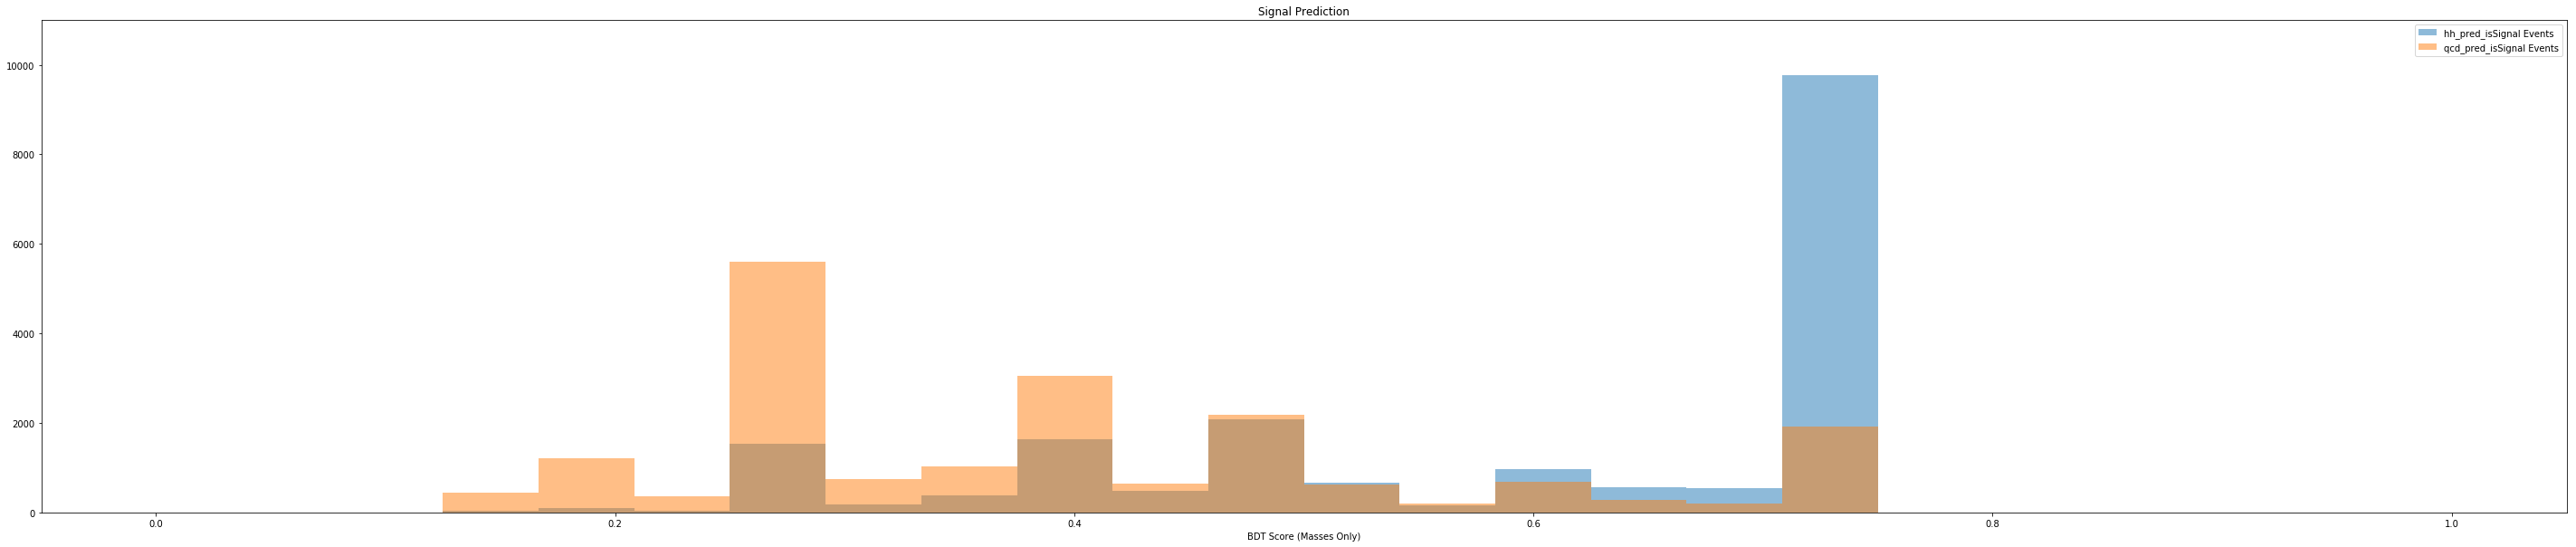

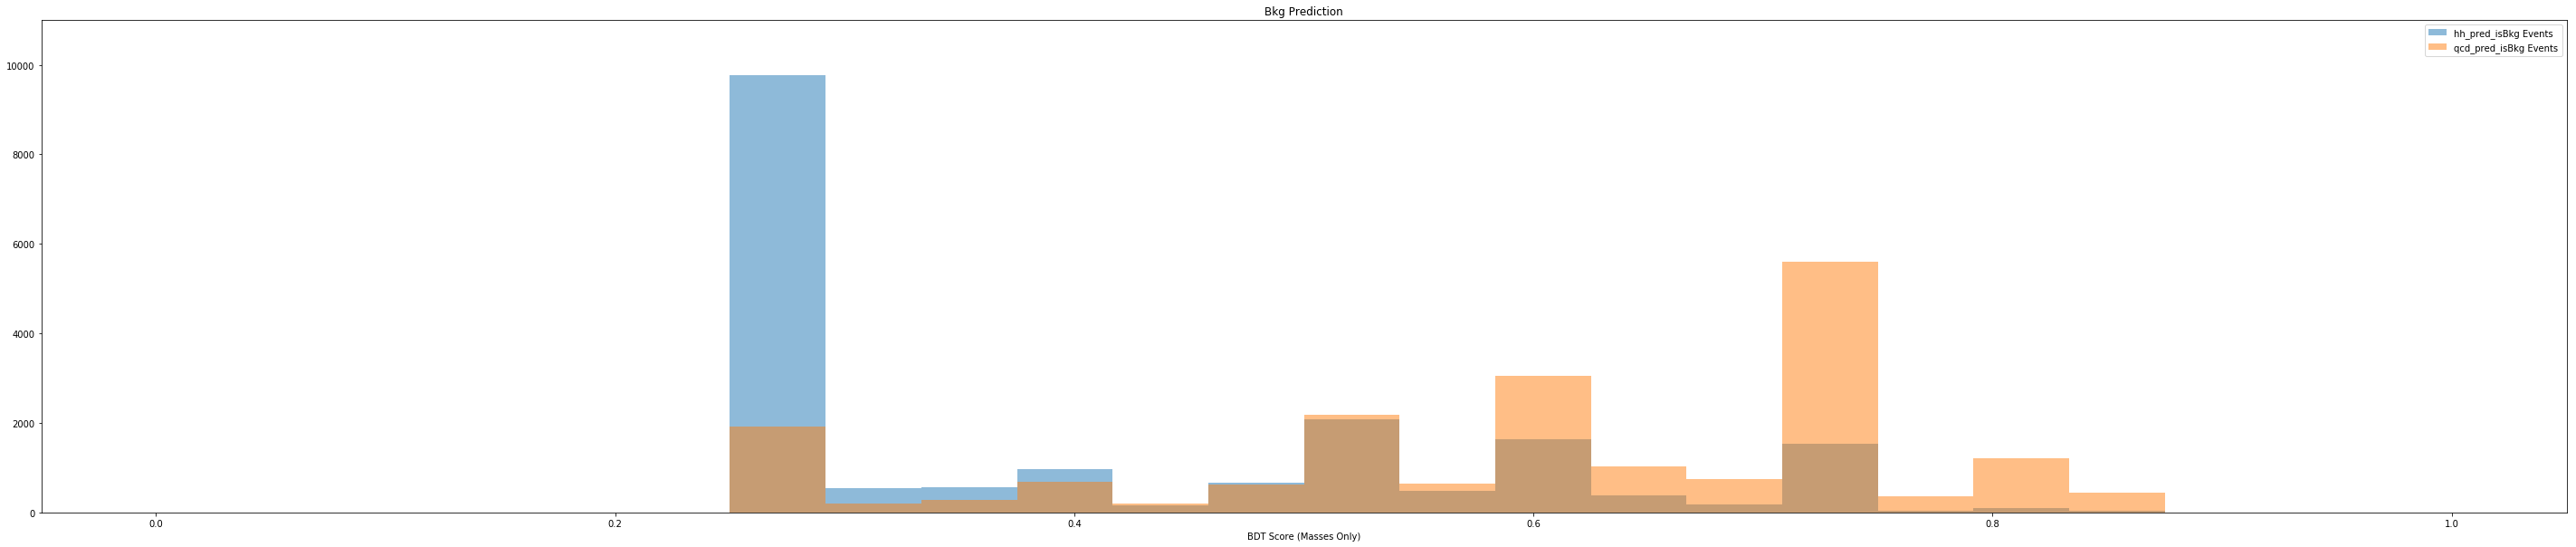

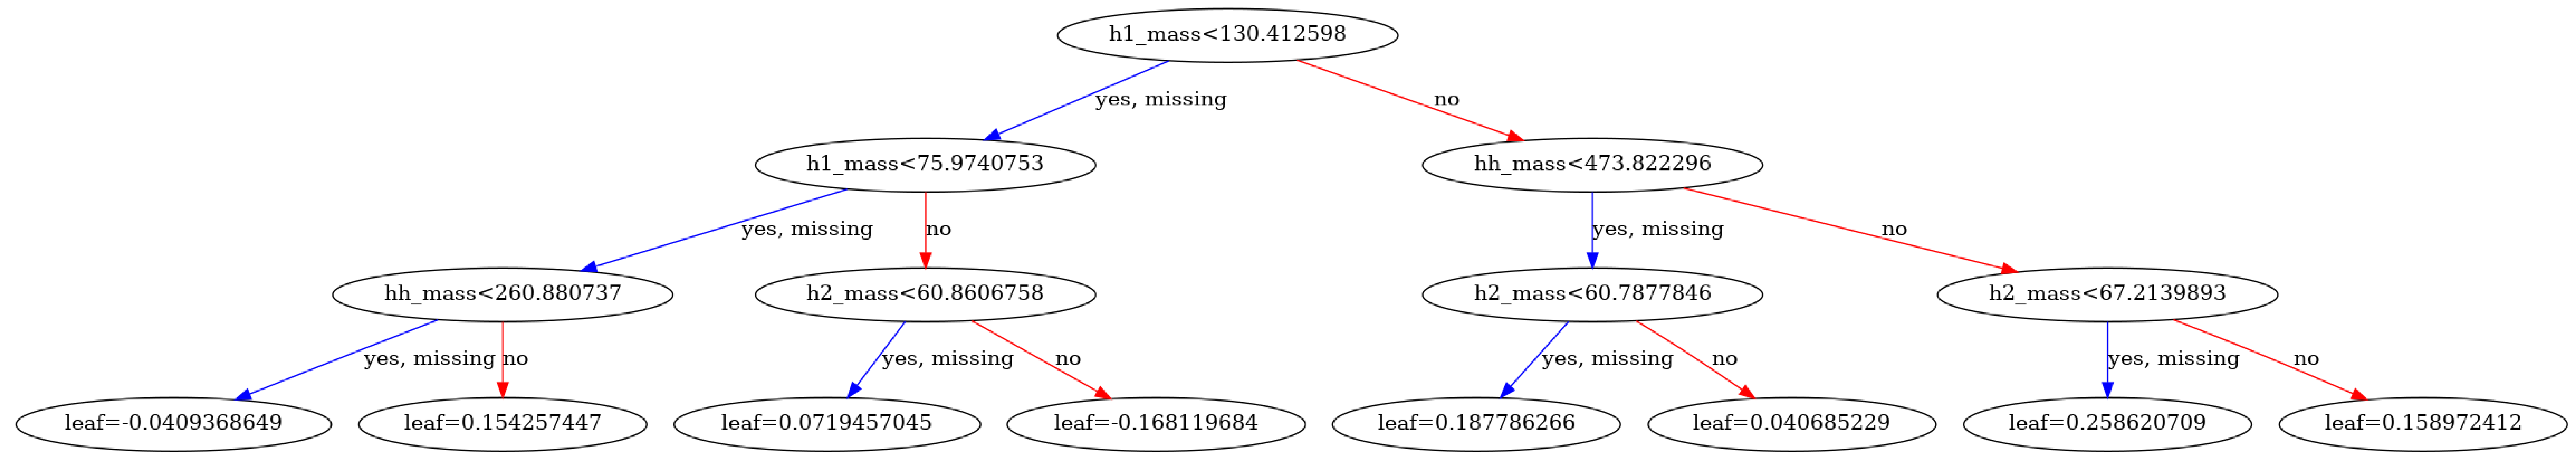

In [38]:
# *** 1. Make some 1D histograms of signal decision outputs
hh_DMatrix = xgb.DMatrix(hh_massesOnly_data, label=hh_massesOnly_labels)
preds_hh = model_massesOnly.predict(hh_DMatrix)
hh_pred_isBkg     = [x[0] for x in preds_hh]
hh_pred_isSignal  = [x[1] for x in preds_hh]
#plt.hist(preds_hh)

# *** 2. Make some 1D histograms of background decision outputs
qcd_DMatrix = xgb.DMatrix(qcd_massesOnly_data, label=qcd_massesOnly_labels)
preds_qcd = model_massesOnly.predict(qcd_DMatrix)
qcd_pred_isBkg    = [x[0] for x in preds_qcd]
qcd_pred_isSignal = [x[1] for x in preds_qcd]
#plt.hist(preds_qcd)

# *** 3. Make dict for plotting with borrowed functions
predictionResults = {'hh_pred_isSignal':hh_pred_isSignal, 'hh_pred_isBkg':hh_pred_isBkg, 'qcd_pred_isSignal':qcd_pred_isSignal, 'qcd_pred_isBkg':qcd_pred_isBkg,}
compareManyHistograms( predictionResults, ['hh_pred_isSignal', 'qcd_pred_isSignal'], 2, 'Signal Prediction', 'BDT Score (Masses Only)', 0, 1, 25 )
compareManyHistograms( predictionResults, ['hh_pred_isBkg', 'qcd_pred_isBkg'], 2, 'Bkg Prediction', 'BDT Score (Masses Only)', 0, 1, 25 )

# *** 4. Make plot of 0th tree
xgb.plot_tree(model_massesOnly,num_trees=0)
fig = plt.gcf()
#fig.set_size_inches(150, 100)
plt.show()
#plt.savefig('tree0.png')

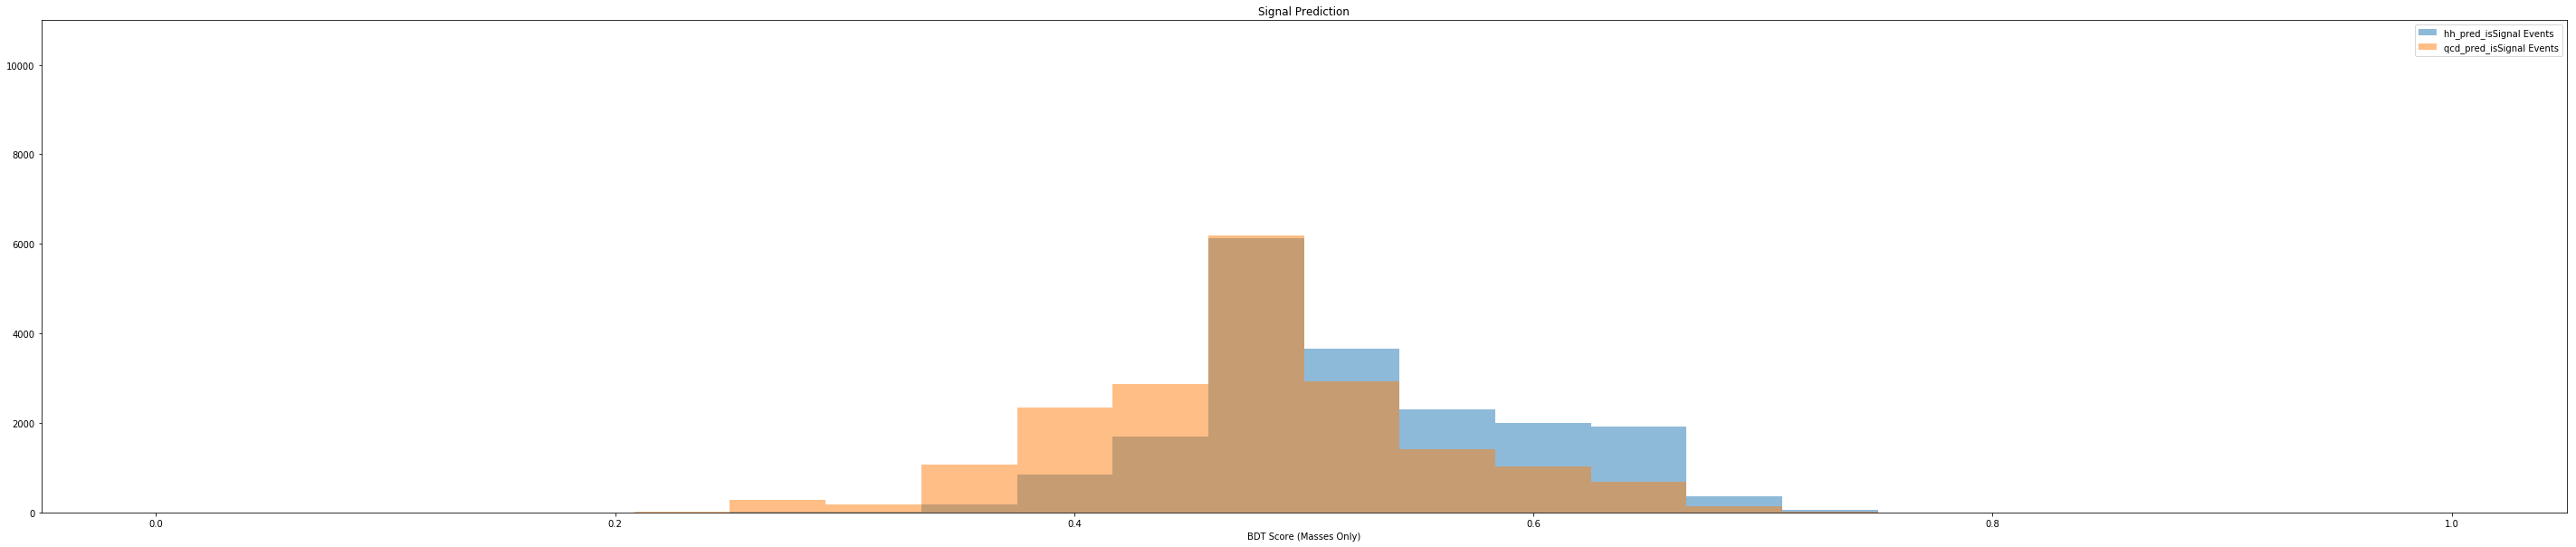

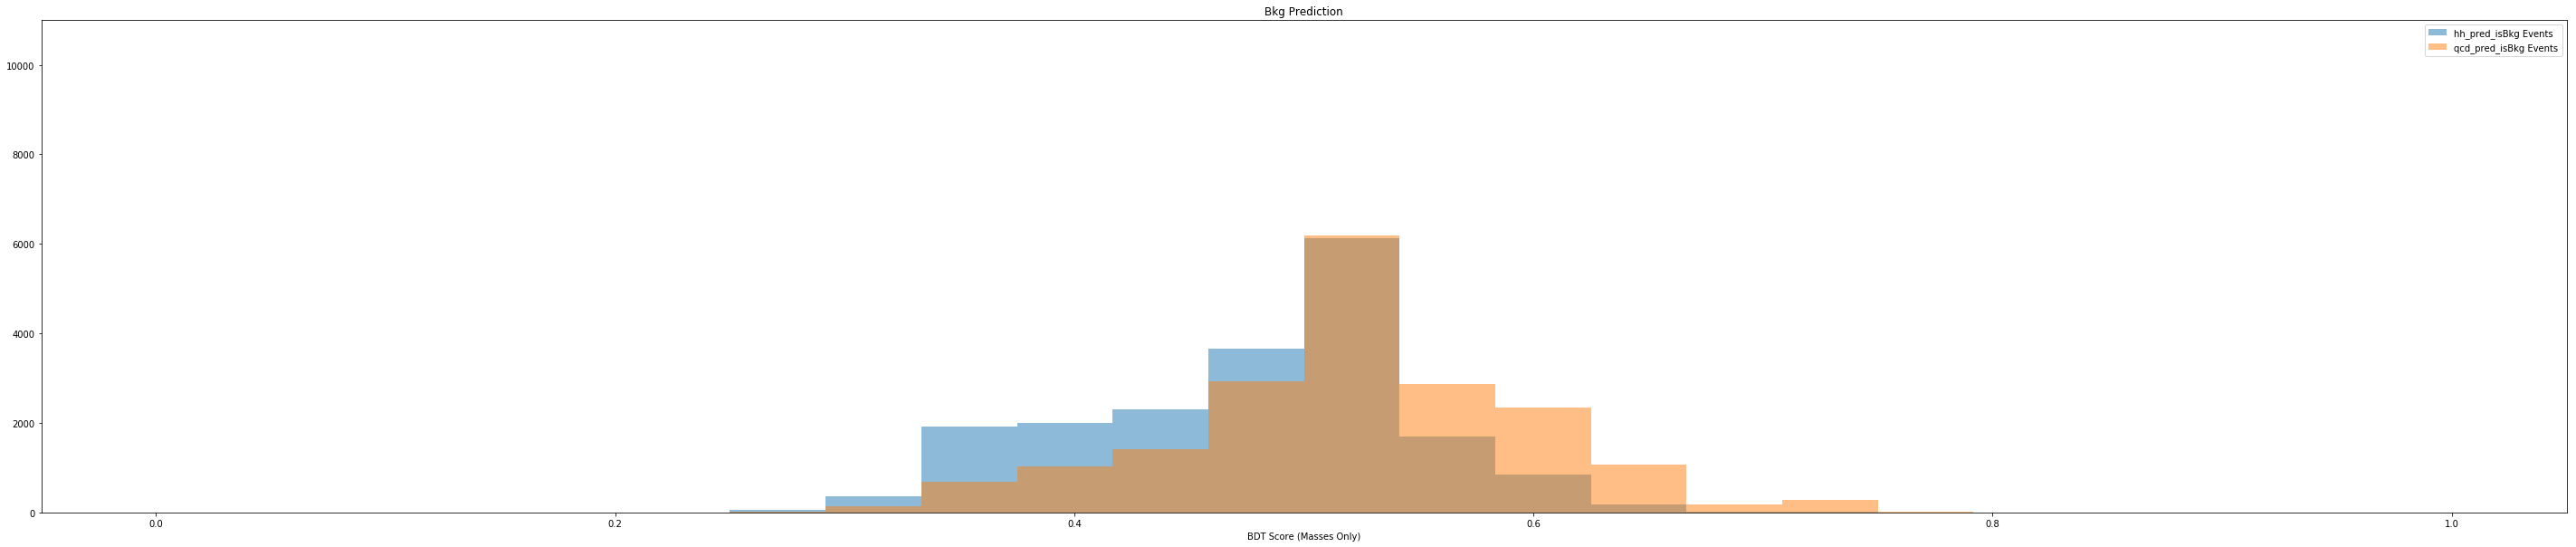

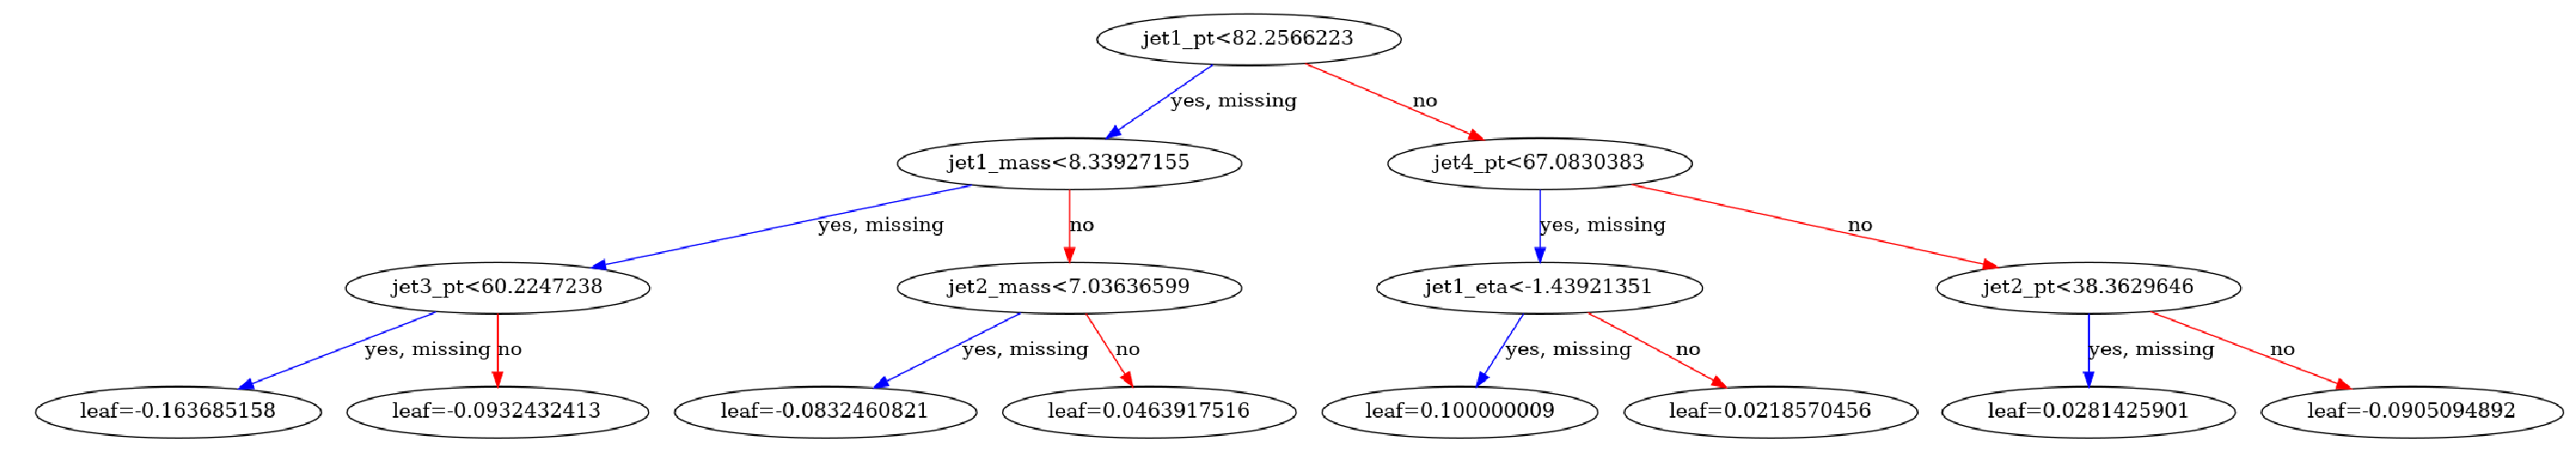

In [39]:
# *** 1. Make some 1D histograms of signal decision outputs
hh_DMatrix = xgb.DMatrix(hh_angularJetInfo_data, label=hh_angularJetInfo_labels)
preds_hh = model_angularJetInfo.predict(hh_DMatrix)
hh_pred_isBkg     = [x[0] for x in preds_hh]
hh_pred_isSignal  = [x[1] for x in preds_hh]
#plt.hist(preds_hh)

# *** 2. Make some 1D histograms of background decision outputs
qcd_DMatrix = xgb.DMatrix(qcd_angularJetInfo_data, label=qcd_angularJetInfo_labels)
preds_qcd = model_angularJetInfo.predict(qcd_DMatrix)
qcd_pred_isBkg    = [x[0] for x in preds_qcd]
qcd_pred_isSignal = [x[1] for x in preds_qcd]
#plt.hist(preds_qcd)

# *** 3. Make dict for plotting with borrowed functions
predictionResults = {'hh_pred_isSignal':hh_pred_isSignal, 'hh_pred_isBkg':hh_pred_isBkg, 'qcd_pred_isSignal':qcd_pred_isSignal, 'qcd_pred_isBkg':qcd_pred_isBkg,}
compareManyHistograms( predictionResults, ['hh_pred_isSignal', 'qcd_pred_isSignal'], 2, 'Signal Prediction', 'BDT Score (Masses Only)', 0, 1, 25 )
compareManyHistograms( predictionResults, ['hh_pred_isBkg', 'qcd_pred_isBkg'], 2, 'Bkg Prediction', 'BDT Score (Masses Only)', 0, 1, 25 )

# *** 4. Make plot of 0th tree
xgb.plot_tree(model_angularJetInfo,num_trees=0)
fig = plt.gcf()
#fig.set_size_inches(150, 100)
plt.show()
#plt.savefig('tree0.png')